In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import re
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

Sentiment analysis is a computational task that involves classifying text documents according to the sentiment they express, such as positive, negative, or neutral. It has a wide range of applications, including social media monitoring, customer feedback analysis, and market research. 
In this post, I will implement a naive Bayes classifier for sentiment analysis of movie reviews and evaluate its performance on the Rotten Tomatoes movie reviews dataset.


## Dataset:
The Rotten Tomatoes movie review dataset downloaded from kaggle ( https://www.kaggle.com/datasets/ulrikthygepedersen/rotten-tomatoes-reviews ) consists of 480001 reviews. The dataset includes the text of each review and a binary label indicating whether the review is "fresh" (positive) or "rotten" (negative).


## Preprocessing:
Before training the classifier, I have preprocessed the dataset by first reading the CSV file containing the reviews and labels and storing them as a list (rotten_tomatoes_dataset) of tuples. 

In [46]:
rotten_tomatoes_dataset=[]
with open('rt_reviews.csv', encoding="ISO-8859-1") as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        rotten_tomatoes_dataset.append((row[1],row[0]))
len(rotten_tomatoes_dataset)

480001

Then, I split the data into three sets: train_documents, dev_documents, and test_documents. I have used 60% of the data for training, 20% for validation, and 20% for testing. This ensures that there is enough data for training and testing, while also having a separate set for tuning the model's hyperparameters.


In [47]:
train_index = int(len(rotten_tomatoes_dataset) * 0.6)
dev_index = int(len(rotten_tomatoes_dataset) * 0.8)
train_documents = rotten_tomatoes_dataset[:train_index]
dev_documents = rotten_tomatoes_dataset[train_index:dev_index]
test_documents = rotten_tomatoes_dataset[dev_index:]
print(f"Number of training documents: {len(train_documents)}")
print(f"Number of validation documents: {len(dev_documents)}")
print(f"Number of testing documents: {len(test_documents)}")


Number of training documents: 288000
Number of validation documents: 96000
Number of testing documents: 96001


Next, I have counted the number of fresh and rotten documents in the training set. This information will be useful for calculating the prior probabilities of each class in the Naive Bayes classifier.


In [48]:
# Count the number of fresh and rotten documents
fresh_count = sum(1 for doc in train_documents if doc[1] == "fresh")
rotten_count = len(train_documents) - fresh_count
print(fresh_count, rotten_count)

144170 143830


 I have then counted the occurrence of each word in the training set, excluding stop words (common words like "the" and "and" that are unlikely to be informative for sentiment analysis). 

In [49]:
# Define a list of stop words
stop_words = ["a", "an", "and", "are", "as", "at", "be", "by", "for", "from",
              "has", "he", "in", "is", "it","it's", "its", "of", "on", "this","that", "the",
              "to", "was", "were", "will", "with"]

In [50]:
# Count the occurrence of each word
word_count = {}
for doc in train_documents:
    # words = doc[0].lower().split()
    words = [word.lower() for word in doc[0].split() if word.lower() not in stop_words]
    for word in words:
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

Next, I created a reverse index of the dictionary and printed the top 5 words with highest count.


In [51]:
#creating a reverse index of the dictionary and prinitng the top 5 words with highest count
sorted_word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
print((sorted_word_count)[:5])
sorted_word_count= dict(sorted_word_count)

[('but', 54993), ('film', 33828), ('movie', 25191), ('you', 25176), ('not', 25096)]


I  have also removed rare words that occur fewer than two times in the training set to reduce noise in the data. This step is important because rare words can have a significant impact on the classifier's performance, but they may not be reliable indicators of sentiment due to their low frequency.
(Note that I saw ~2-3% drop in accuracy on validation set when words with occurrences less than 5 were removed, so i decided to consider words with occurrences more than 2)


In [52]:
word_set = set()
for word, count in sorted_word_count.items():
    if count >= 2:
        word_set.add(word)
print("Rare words with count less than 2 removed.")

Rare words with count less than 2 removed.


Moving on to the Naive Bayes classifier, which is a probabilistic model that calculates the probability of a document belonging to a certain class given the words in the document. It assumes that the words are conditionally independent given the class, which allows us to calculate the probability of the document as the product of the probabilities of each word given the class.
To train the Naive Bayes classifier, I have calculated the frequency of each word in ‘fresh’ and ‘rotten’ documents separately. 


In [53]:
# Calculate word frequencies in fresh and rotten documents
word_freqs = {}
for word in word_set:
    word_freqs[word] = {"fresh": 0, "rotten": 0}
for doc in train_documents:
    words = [word.lower() for word in doc[0].split() if word.lower() not in stop_words]
    for word in words:
        if word in word_set:
            if doc[1] == "fresh":
                word_freqs[word]["fresh"] += 1
            else:
                word_freqs[word]["rotten"] += 1

In [54]:
# Convert word frequencies to arrays
fresh_word_freqs = np.zeros(len(word_set))
rotten_word_freqs = np.zeros(len(word_set))
for i, word in enumerate(word_set):
    fresh_word_freqs[i] = word_freqs[word]["fresh"]
    rotten_word_freqs[i] = word_freqs[word]["rotten"]

I have then applied Laplace smoothing by adding a small value (alpha) to the word counts to avoid zero probabilities. I have chosen a range of alpha values (from 0 to 1) to tune the model's hyperparameters, and for each alpha value, the log probabilities of each word in fresh and rotten documents is calculated. The resulting fresh_probs and rotten_probs arrays contain the log-probabilities of each word for each class.I have stored the log probabilities in a dictionary for each alpha value, which allows us to quickly look up the probabilities for a given word during testing.


In [55]:
# Apply smoothing and calculate log probabilities for different values of alpha
k = len(word_set)
alpha_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# alpha_values = [ 0.5, 1,5, 10]
accuracies = []
alpha_dictionaries={}
for alpha in alpha_values:
    alpha_dict = {}
    num_f = fresh_word_freqs + alpha
    num_r = rotten_word_freqs + alpha
    den_f = fresh_count + alpha * k
    den_r = rotten_count + alpha * k
   
    fresh_probs = np.log(num_f / den_f)
    rotten_probs = np.log(num_r / den_r)
    for i, word in enumerate(word_set):
        alpha_dict[word] = {"fresh": fresh_probs[i], "rotten": rotten_probs[i]}
    print(f"Traning completed for alpha = {alpha}\n")
    alpha_dictionaries[alpha]= alpha_dict

    # Make predictions on the development set and calculate accuracy
    correct = 0
    for doc in dev_documents:
        # words = set(doc[0].lower().split())
        words = set([word.lower() for word in doc[0].split() if word.lower() not in stop_words])
        words &= word_set
        fresh_log_prob = sum([alpha_dict[word]["fresh"] for word in words])
        rotten_log_prob = sum([alpha_dict[word]["rotten"] for word in words])

        
        fresh_log_prob += np.log(fresh_count / len(dev_documents))
        rotten_log_prob += np.log(rotten_count / len(dev_documents))
        if fresh_log_prob > rotten_log_prob:
            prediction = "fresh"
        else:
            prediction = "rotten"
        if prediction == doc[1]:
            correct += 1
    accuracies.append(correct / len(dev_documents))

print(f"Accuracies : {accuracies}")



C:\Users\prash\AppData\Local\Temp\ipykernel_22888\3351790211.py:14: RuntimeWarning: divide by zero encountered in log
  fresh_probs = np.log(num_f / den_f)
C:\Users\prash\AppData\Local\Temp\ipykernel_22888\3351790211.py:15: RuntimeWarning: divide by zero encountered in log
  rotten_probs = np.log(num_r / den_r)


Traning completed for alpha = 0

Traning completed for alpha = 0.1

Traning completed for alpha = 0.2

Traning completed for alpha = 0.3

Traning completed for alpha = 0.4

Traning completed for alpha = 0.5

Traning completed for alpha = 0.6

Traning completed for alpha = 0.7

Traning completed for alpha = 0.8

Traning completed for alpha = 0.9

Traning completed for alpha = 1

Accuracies : [0.7941979166666666, 0.805125, 0.8064583333333334, 0.8071875, 0.8074791666666666, 0.80765625, 0.8075416666666667, 0.80746875, 0.8073854166666666, 0.807375, 0.8070520833333333]


In [40]:
max_accuracy= max(accuracies)
max_alpha= alpha_values[accuracies.index(max_accuracy)]
print(f"\nMaximum accuracy : {max_accuracy} at alpha = {max_alpha}")


Maximum accuracy : 0.80765625 at alpha = 0.5


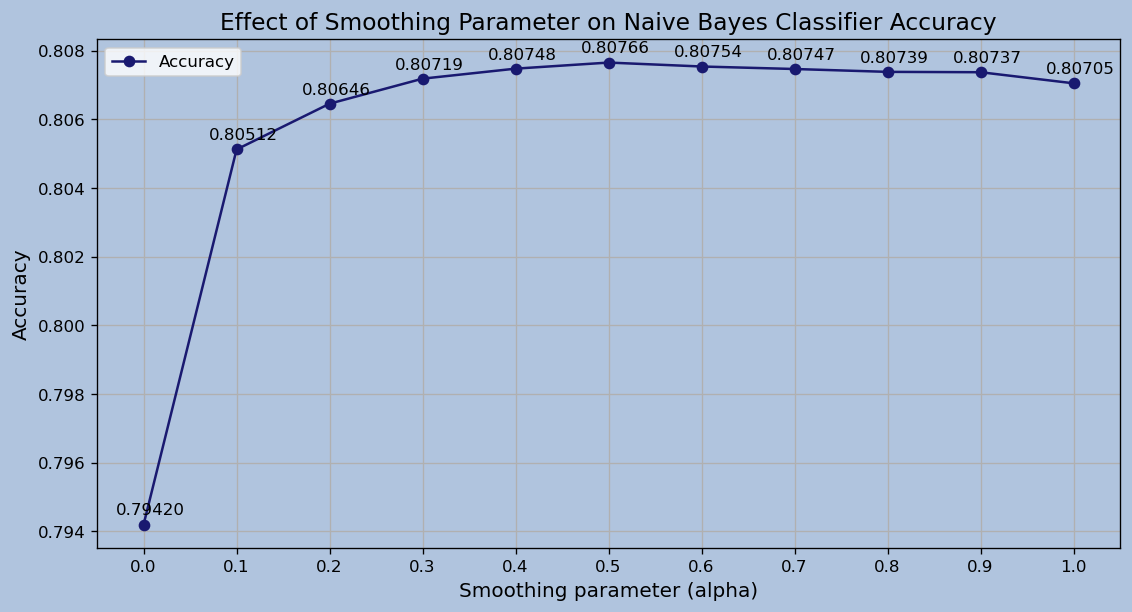

In [56]:
# Plot the accuracies for different values of alpha
mpl.rcParams['figure.figsize'] = [11.0, 5.5]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['axes.grid'] = True
fig, ax = plt.subplots()
fig.patch.set_facecolor('lightsteelblue')
ax.set_facecolor('lightsteelblue')

plt.plot(alpha_values, accuracies, linestyle='-', color = 'midnightblue', marker='o', label='Accuracy')

plt.xlabel("Smoothing parameter (alpha)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Effect of Smoothing Parameter on Naive Bayes Classifier Accuracy", fontsize=14)
plt.xticks(alpha_values, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend(loc='best')

for i in range(len(alpha_values)):
    plt.annotate("{:.5f}".format(accuracies[i]), xy=(alpha_values[i], accuracies[i]), ha='center', va='bottom', fontsize=10, textcoords='offset points', xytext=(4, 4))

plt.show()

## Testing and Evaluation
To evaluate the Naive Bayes classifier, I have used the development set to tune the hyperparameters (alpha values) and measure the classifier's accuracy. The predictions on each document in the development set is made by calculating the log probability of each word in the document given the class and summing the probabilities. Then, I added the log prior probability of the class (fresh or rotten) and chose the class with the highest probability as the predicted class for the document.
The accuracy of the classifier is calculated as the percentage of correctly classified documents in the development set. This entire process is repeated for each alpha value and the alpha value that gives the highest accuracy on the validation set is chosen.


From the described process, the following are the key findings:
For alpha values, alpha =  [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
the accuracies were  : [0.7941979166666666, 0.805125, 0.8064583333333334, 0.8071875, 0.8074791666666666, 0.80765625, 0.8075416666666667, 0.80746875, 0.8073854166666666, 0.807375, 0.8070520833333333]

**Maximum accuracy for development set : 0.80765625 at alpha = 0.5**


The top 10 words that predicts each class were calculated as follows:

In [59]:
def top_words(word_set, word_freqs, fresh_count, rotten_count, alpha):    
    # Calculate the conditional probabilities of each word for each class
    k = len(word_set)
    fresh_probs = np.log((np.array([word_freqs[word]["fresh"] for word in word_set]) + alpha) / (fresh_count + alpha * k))
    rotten_probs = np.log((np.array([word_freqs[word]["rotten"] for word in word_set]) + alpha) / (rotten_count + alpha * k))

    # Sort the words based on their probabilities for each class
    fresh_sorted_indices = np.argsort(fresh_probs)[::-1][:10]
    rotten_sorted_indices = np.argsort(rotten_probs)[::-1][:10]

    # Print the top 10 words for each class
    print("Top 10 words predicting 'fresh':\n")
    for i in fresh_sorted_indices:
        word = list(word_set)[i]
        print(word, np.exp(fresh_probs[i]))

    print("\nTop 10 words predicting 'rotten':")
    for i in rotten_sorted_indices:
        word = list(word_set)[i]
        print(word, np.exp(rotten_probs[i]))

In [60]:
# derive top 10 wrords
top_words(word_set, word_freqs,fresh_count, rotten_count, alpha =0.5)

Top 10 words predicting 'fresh':

but 0.13213364922305063
film 0.09216630000895908
you 0.06458235862110157
not 0.05792777009068555
movie 0.054752282070935826
one 0.054155011597001694
his 0.0531794698229093
about 0.04964064226484964
more 0.0482519884129528
all 0.043518619907024894

Top 10 words predicting 'rotten':
but 0.14182546092713907
film 0.07633840876683917
movie 0.07075443477220376
not 0.06709992322035757
you 0.060832909549592654
like 0.060593596378394
more 0.06028946922332906
than 0.055034550839091805
have 0.05415208352029676
so 0.049550290665789185


Finally, the performance of the classifier is tested on the test set, which is independent of the training and development sets. The accuracy of the classifier on the test set is calculated using the alpha value that gave the highest accuracy on the validation set, which is **alpha = 0.5**.


In [42]:
# Testing on test Datset
alpha_dict = alpha_dictionaries[max_alpha]
correct = 0
for doc in test_documents:
    words = set([word.lower() for word in doc[0].split() if word.lower() not in stop_words]) & word_set
    fresh_log_prob = sum([alpha_dict[word]["fresh"] for word in words])
    rotten_log_prob = sum([alpha_dict[word]["rotten"] for word in words])
    if fresh_log_prob > rotten_log_prob:
        prediction = "fresh"
    else:
        prediction = "rotten"
    if prediction == doc[1]:
        correct += 1

accuracy = correct / len(test_documents)
print(f"Accuracy on the test set for alpha = {max_alpha}: {accuracy:.4f}")


Accuracy on the test set for alpha = 0.5: 0.8065


 **Maximum accuracy of Naive Bayes Classifier for test set : 0.8065 at alpha = 0.5.**

## Conclusion
In this post, I have implemented a naive Bayes classifier for sentiment analysis using a dataset of movie reviews from Rotten Tomatoes. The classifier is implemented from scratch using Python and NumPy libraries.
This implementation achieved an accuracy of **~80.65%**, which is reasonable for a simple model like Naive Bayes. 

